In [ ]:
import pandas as pd
import numpy as np
import gzip
import json
import re
import string
import nltk
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings("ignore") #, category=DeprecationWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

pd.set_option('display.max_colwidth', 500)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Office Product Amazon Reviews as pandasDF
def parse(path):
    g = gzip.open(path, "rb")
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")
# For colab
data_path = "/content/drive/MyDrive/centennial/nlp/Office_Products_5.json.gz" #Change1: "../Office_Products_5.json.gz"
data = getDF(data_path)

data.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')

In [ ]:
# Considered only required columns for further analysis
df = data[["reviewerID","asin","overall","reviewText","summary"]]

print("before", df[df["reviewText"].isnull()].overall.value_counts())

# Initial trail deleting the rows with null values
df.dropna(subset=['reviewText'], inplace=True)

df["overall"].value_counts()

before 5.0    184
4.0     25
3.0      2
2.0      2
Name: overall, dtype: int64


5.0    570809
4.0    122864
3.0     50700
1.0     31697
2.0     24074
Name: overall, dtype: int64

In [ ]:
sentiment_values = []
for i in df['overall'].values:
    if (i >= 4.):
        sentiment_values.append('positive')
    elif (i < 4. or i > 2.):
        sentiment_values.append('neutral')
    elif (i <= 2.):
        sentiment_values.append('negative')

df['sentiment'] = sentiment_values
df.head()

,reviewerID,asin,overall,reviewText,summary,sentiment
0,A2NIJTYWADLK57,0140503528,4.0,kids like story BUT while i really wanted a board book this one is just so small. wish larger,"good story, small size book though",positive
1,A2827D8EEURMP4,0140503528,4.0,"Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection",Good,positive
2,APB6087F4J09J,0140503528,5.0,Every story and book about Corduroy is Fantastic. This book is great and I bought all the Corduroy books for my 2 boys and now for their total of 5 children. You have to buy a Corduroy bear for everyone who has the books. Love to hold them while the stories are read.,Best Books for All Children,positive
3,A2DHERRZIPFU7X,0140503528,5.0,"I purchased this book for my first grade classroom. I read the book to the students during a math lesson. The first day, I split the students into groups and had them count how many pockets they had all together. They recorded it on a chart and answered questions like: Who had the most? Who had the least? Choose two numbers and compare using <,>,=. The second day we referenced the book and compared pockets of the boys vs the girls. They again answered questions about the numbers. They loved ...",Great for Math!,positive
4,A2XCLJRGFANRC,0140503528,5.0,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a ...",Love Corduroy,positive


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    """
    Preprocesses a given text by performing the following steps:
    1. Convert text to lowercase
    2. Remove digits
    3. Remove punctuations
    4. Remove special characters
    5. Remove stop words
    6. Lemmatize the text
    
    Args:
    text (str): The text to preprocess
    
    Returns:
    str: The preprocessed text
    """
    # Convert text to lowercase
    text = text.lower()
    
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    
    # Remove punctuations
    text = ''.join([i for i in text if i not in string.punctuation])
    
    # Remove special characters
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if not word in stop_words]
    
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into a single string
    text = ' '.join(words)
    
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import random
n_samples = random.randint(5000, 10000)
#df_random['preprocessed_text'] = df_random['reviewText'].apply(lambda x: preprocess_text(x))

In [ ]:
import random

# Get the number of classes and minimum number of samples per class
num_classes = len(df['sentiment'].unique())
min_samples_per_class = n_samples // num_classes

# Group the dataframe by the class column and take a random sample of the same size for each group
df_random = df.groupby('sentiment').apply(lambda x: x.sample(n=min_samples_per_class, replace=True))

# If the total number of samples is not evenly divisible by the number of classes,
# take an additional random sample from the remaining samples for each class
remaining_samples = n_samples - min_samples_per_class * num_classes
if remaining_samples > 0:
    for class_label in df['sentiment'].unique():
        class_subset = df[df['sentiment'] == class_label]
        df_random = pd.concat([df_random, class_subset.sample(n=remaining_samples, replace=True)])

# Shuffle the rows of the resulting dataframe to mix the samples from different classes
df_random = df_random.sample(frac=1, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_random['reviewText'], df_random['sentiment'], test_size=0.3, stratify=df_random['sentiment'])

print("Shape of training data: ", x_train.shape)
print("Shape of testing data: ", x_test.shape)
print("Shape of training labels: ", y_train.shape)
print("Shape of testing labels: ", y_test.shape)


Shape of training data:  (5692,)
Shape of testing data:  (2440,)
Shape of training labels:  (5692,)
Shape of testing labels:  (2440,)


In [ ]:
vectorizer1 = TfidfVectorizer(preprocessor=preprocess_text)   #(stop_words='english',analyzer='word')
x_train_matrix = vectorizer1.fit_transform(x_train).toarray() #  sparse matrix of type '<class 'numpy.float64'>
print('shape of vectorized data', x_train_matrix.shape)
print("total number of features",vectorizer1.get_feature_names_out().shape)

x_test_matrix = vectorizer1.transform(x_test).toarray()
print('shape of vectorized test data',  x_test_matrix.shape)

vectorizer1.get_feature_names_out()[:100]

shape of vectorized data (5692, 11313)
total number of features (11313,)
shape of vectorized test data (2440, 11313)


array(['aa', 'aaa', 'aaaaaagh', 'aag', 'aags', 'aawy', 'ab', 'aback',
       'abandon', 'abandoned', 'abandoning', 'abbreviated', 'abbyy',
       'abide', 'abiding', 'ability', 'able', 'abominably', 'abort',
       'abound', 'abpout', 'abrade', 'abraham', 'abridged', 'absence',
       'absolute', 'absolutely', 'absolve', 'absorbent', 'absorbs',
       'abstract', 'absurdly', 'abuse', 'abut', 'abysmal', 'ac',
       'academic', 'accent', 'accept', 'acceptable', 'acceptably',
       'accepted', 'acceptno', 'accepts', 'access', 'accessed',
       'accessible', 'accessing', 'accessory', 'accident', 'accidental',
       'accidentally', 'accidently', 'accolade', 'accommodate',
       'accommodating', 'accomodate', 'accompanied', 'accompanies',
       'accompanying', 'accomplish', 'accord', 'according', 'accordingly',
       'account', 'accountantbookkeeper', 'accounting', 'acct', 'accugel',
       'accumulate', 'accumulated', 'accumulates', 'accumulation',
       'accuracy', 'accuracymovemen

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline

sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

# Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(x_train_matrix, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(x_test_matrix) # make class predictions for X_test_dtm

CPU times: user 277 ms, sys: 48.2 ms, total: 325 ms
Wall time: 235 ms


In [ ]:
from sklearn.linear_model import LogisticRegression # REF (LogisticRegression Solvers): https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, tree, metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier

'''
lr_C = LogisticRegression(max_iter = 1400)
rf_C = RandomForestClassifier()
# LinearSVC(random_state = 42)
svm_C = svm.SVC(probability=True, random_state = 42)
dt_C = tree.DecisionTreeClassifier(criterion="entropy", max_depth =42)
et_C = ExtraTreesClassifier()

rf_C = RandomForestClassifier(class_weight='balanced',
         criterion='entropy',
         max_depth=22,
         min_samples_split=4,
         n_estimators=250,
         random_state=56)


 dt_C = tree.DecisionTreeClassifier(criterion="entropy", max_depth =22, class_weight='balanced', random_state = 42)
 et_C = ExtraTreesClassifier(criterion="entropy", max_depth =22, class_weight='balanced')
 LinearSVC(random_state = 42)'''

lr_C = LogisticRegression(class_weight='balanced',random_state = 0, max_iter = 1400)
gb_C = GradientBoostingClassifier(n_estimators=250, learning_rate=1.0,
     max_depth=22, random_state=56)
svm_C = svm.SVC(probability=True, random_state = 42)
mnb_C = MultinomialNB()

voting_clf = VotingClassifier(
    estimators=[('lr', lr_C),
                ('svm', svm_C),
                ('mnb', mnb_C),
                ('gbc', gb_C)],
    voting='soft')

In [ ]:
final_pipeline = Pipeline([("NLP", TfidfVectorizer(preprocessor=preprocess_text)),
                           ('classifier', voting_clf)])

final_pipeline.fit(x_train, y_train)

Pipeline(steps=[('NLP',
                 TfidfVectorizer(preprocessor=<function preprocess_text at 0x7f491a371d30>)),
                ('classifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=1400,
                                                                  random_state=0)),
                                              ('svm',
                                               SVC(probability=True,
                                                   random_state=42)),
                                              ('mnb', MultinomialNB()),
                                              ('gbc',
                                               GradientBoostingClassifier(learning_rate=1.0,
                                                                          max_depth=22,
                                                                          n_estimators=250,
                                                                          random_state=56))],
                                  voting='soft'))])

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

y_pred = final_pipeline.predict(x_test)
print(f'Model score {final_pipeline.score(x_train, y_train)}')
print(f'Test score {final_pipeline.score(x_test, y_test)}')

# convert categorical labels into binary labels
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)
y_pred_binary = lb.transform(y_pred)

# from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
print('Classifier ROC curve')
print(metrics.roc_curve(y_test_binary, y_pred_binary))


cf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cf_matrix)

Model score 0.9806746310611384
Test score 0.7954918032786885
Classifier ROC curve
(array([0.        , 0.18196721, 1.        ]), array([0.        , 0.77295082, 1.        ]), array([2, 1, 0]))
[[998 222]
 [277 943]]


<Axes: >

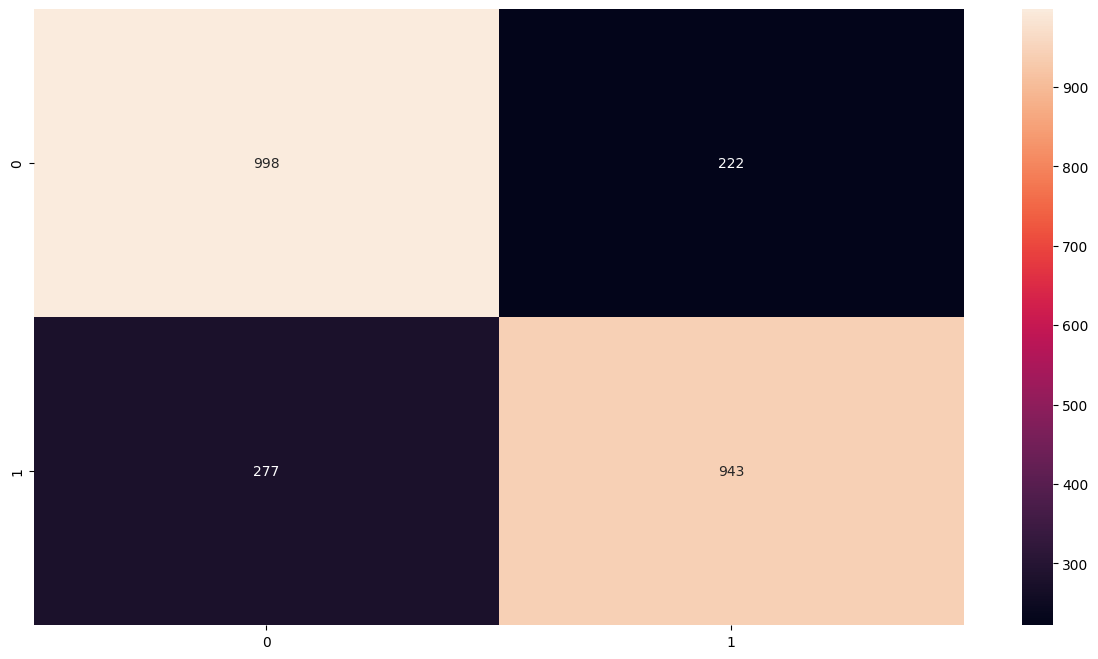

In [ ]:
from seaborn import heatmap
plt.figure(figsize=(15,8))
heatmap(cf_matrix, annot=True, fmt=".0f")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import defaultdict

tfidf = TfidfVectorizer(stop_words='english',analyzer='word')
x_train_matrix = tfidf.fit_transform(x_train).toarray()
x_test_matrix = tfidf.transform(x_test).toarray()
accuracy_dict = defaultdict(int)
for name, clf in voting_clf.named_estimators_.items():
    clf.fit(x_train_matrix, y_train)
    y_pred = clf.predict(x_test_matrix)
    print(clf.__class__.__name__)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_dict[clf.__class__.__name__] = accuracy
    print('Accuracy: ', accuracy)
    print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
    print('Classification Report: \n' , classification_report(y_test, y_pred))
    print('***********************************************************************\n')

LogisticRegression
Accuracy:  0.821917808219178
Precision:  0.866879265233941
Recall:  0.821917808219178
F1 Score:  0.8381938304684294
Classification Report: 
               precision    recall  f1-score   support

     neutral       0.41      0.67      0.51       233
    positive       0.94      0.85      0.89      1446

    accuracy                           0.82      1679
   macro avg       0.68      0.76      0.70      1679
weighted avg       0.87      0.82      0.84      1679

***********************************************************************

SVC
Accuracy:  0.8642048838594402
Precision:  0.8526122660377081
Recall:  0.8642048838594402
F1 Score:  0.80623851149148
Classification Report: 
               precision    recall  f1-score   support

     neutral       0.78      0.03      0.06       233
    positive       0.86      1.00      0.93      1446

    accuracy                           0.86      1679
   macro avg       0.82      0.51      0.49      1679
weighted avg       0.8

Finding the classifier with the highest accuracy:

In [ ]:
print('The classifier with the highest accuracy is: ')
highest_accuracy_classifier = max(accuracy_dict, key=accuracy_dict.get)
print(highest_accuracy_classifier)

The classifier with the highest accuracy is: 
SVC


### Comparing accuracies:

In [ ]:
#ml_model_accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_dict

defaultdict(int,
            {'LogisticRegression': 0.821917808219178,
             'SVC': 0.8642048838594402,
             'MultinomialNB': 0.8612269207861822,
             'GradientBoostingClassifier': 0.8469326980345444})

In [ ]:
lexicon_model_accuracy_df = pd.DataFrame(accuracy_list, columns=['Lexicon Model', 'Accuracy'])
preprocessed_lexicon_model_accuracy_df = pd.DataFrame(preprocessed_accuracy_list, columns=['Lexicon Model', 'Accuracy'])

In [ ]:
lexicon_model_accuracy_df

,Lexicon Model,Accuracy
0,VADR,83.524027
1,TextBlob,81.006865
2,Sentiwordnet,61.212815


In [ ]:
preprocessed_lexicon_model_accuracy_df

,Lexicon Model,Accuracy
0,VADR,5.835240
1,TextBlob,65.217391
2,Sentiwordnet,76.315789


### K Nearest Neighbor Collaborative Filtering approach:

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195813 sha256=94860e4fd91f147a41346d8c294fc5efd0f35845be1768181937bd5f2be34a84
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_random[['reviewerID', 'asin', 'overall']], reader)

# Build a training set from the entire dataset
trainset = data.build_full_trainset()

In [ ]:
model = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': True})
model.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
all_asins = df_random['asin'].unique()

def recommend_products(user_id):
  rated_asins = df_random[df_random['reviewerID'] == user_id]['asin'].unique()
  unrated_asins = list(set(all_asins) - set(rated_asins))

  predictions = []
  for asin in unrated_asins:
      pred = model.predict(user_id, asin)
      predictions.append((asin, pred.est))

  predictions.sort(key=lambda x: x[1], reverse=True)
  return [asin for asin, rating in predictions[:10]]

In [ ]:
user_id = 'A27TVBD5GVDHD8'
recommendations = recommend_products(user_id)
print(f'Recommended products of {user_id} are: {", ".join(recommendations)}')

Recommended products of A27TVBD5GVDHD8 are: B015I4D16C, B00B5WCCQW, B012O5VKMA, B000K7RK6A, B000IOHYUW, B00ME26SYE, B006ZZGD3W, B00CQF69SO, B0045Z8O7C, B000FPIUAW


### SVD Collaborative Filtering approach:

In [ ]:
from surprise import SVD

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_random[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

In [ ]:
svd = SVD()
svd.fit(trainset)

In [ ]:
all_asins = df_random['asin'].unique()

def recommend_products(user_id):
  rated_asins = df_random[df_random['reviewerID'] == user_id]['asin'].unique()
  unrated_asins = set(all_asins) - set(rated_asins)

  predictions = []
  for asin in unrated_asins:
    pred = svd.predict(user_id, asin)
    predictions.append((asin, pred.est))
  
  predictions.sort(key=lambda x: x[1], reverse=True)
  return [asin for asin, _ in predictions[:10]]

In [ ]:
user_id = 'A27TVBD5GVDHD8'
recommendations = recommend_products(user_id)
print(f'Recommended products of {user_id} are: {", ".join(recommendations)}')

Recommended products of A27TVBD5GVDHD8 are: B00006IFEU, B00A89YZ6S, B001CD7M1O, B001CJRM36, B000J09D2W, B0018NC2SQ, B0016T9MXK, B00004Z6JX, B003YFHCKY, B00178QQJ8


### Enhancing the rating:

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


# Preprocess the review text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
reviews_processed = []
for review in df_random['reviewText']:
    tokens = word_tokenize(review.lower())
    tokens_filtered = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    reviews_processed.append(tokens_filtered)

# Extract adjectives and verbs as opinion words
opinion_words = []
for review in reviews_processed:
    pos_tags = nltk.pos_tag(review)
    for word, pos in pos_tags:
        if pos.startswith('JJ') or pos.startswith('VB'):
            opinion_words.append(word)

# Determine the sentiment orientation of each opinion word
positive_reviews = df_random[df_random['sentiment'] == 'positive']['reviewText'].tolist()
negative_reviews = df_random[df_random['sentiment'] == 'negative']['reviewText'].tolist()
positive_opinion_words = []
negative_opinion_words = []
for word in opinion_words:
    freq_pos = sum([1 for review in positive_reviews if word in review])
    freq_neg = sum([1 for review in negative_reviews if word in review])
    if freq_pos > 0 or freq_neg > 0:
        ratio = freq_pos / freq_neg if freq_neg > 0 else freq_pos
        if ratio > 1:
            positive_opinion_words.append(word)
        elif ratio < 1:
            negative_opinion_words.append(word)

# Calculate the overall sentiment strength of each review
sentiment_strengths = []
for review in df_random['reviewText']:
    sentiment_strength = 0
    num_opinion_words = 0
    for token in word_tokenize(review.lower()):
        if token in positive_opinion_words:
            sentiment_strength += 1
            num_opinion_words += 1
        elif token in negative_opinion_words:
            sentiment_strength -= 1
            num_opinion_words += 1
    if num_opinion_words > 0:
        overall_sentiment_strength = sentiment_strength / num_opinion_words
    else:
        overall_sentiment_strength = 0
    sentiment_strengths.append(overall_sentiment_strength)

# Map the overall sentiment strength to a corresponding rating on a 5-point scale
max_possible_sentiment_strength = len(positive_opinion_words) + len(negative_opinion_words)
ratings = []
for sentiment_strength in sentiment_strengths:
    if sentiment_strength > 0:
        rating = (sentiment_strength / max_possible_sentiment_strength) * 3 + 4
    elif sentiment_strength < 0:
        rating = (sentiment_strength / max_possible_sentiment_strength) * 3 + 2
    else:
        rating = 3
    ratings.append(rating)



# Add the ratings to the dataframe
df_random['rating'] = ratings

# # Save the results to a CSV file
# reviews_df.to_csv('reviews_with_ratings.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_random['enhanced_rating'] = df_random[['overall', 'rating']].mean(axis=1)

In [ ]:
sentiment_values = []
for i in df_random['enhanced_rating'].values:
    if (i >= 4.):
        sentiment_values.append('positive')
    elif (i < 4. or i > 2.):
        sentiment_values.append('neutral')
    elif (i <= 2.):
        sentiment_values.append('negative')

df_random['enhanced_sentiment'] = sentiment_values
df.head()

,reviewerID,asin,overall,reviewText,summary,sentiment
0,A2NIJTYWADLK57,0140503528,4.0,kids like story BUT while i really wanted a board book this one is just so small. wish larger,"good story, small size book though",positive
1,A2827D8EEURMP4,0140503528,4.0,"Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection",Good,positive
2,APB6087F4J09J,0140503528,5.0,Every story and book about Corduroy is Fantastic. This book is great and I bought all the Corduroy books for my 2 boys and now for their total of 5 children. You have to buy a Corduroy bear for everyone who has the books. Love to hold them while the stories are read.,Best Books for All Children,positive
3,A2DHERRZIPFU7X,0140503528,5.0,"I purchased this book for my first grade classroom. I read the book to the students during a math lesson. The first day, I split the students into groups and had them count how many pockets they had all together. They recorded it on a chart and answered questions like: Who had the most? Who had the least? Choose two numbers and compare using <,>,=. The second day we referenced the book and compared pockets of the boys vs the girls. They again answered questions about the numbers. They loved ...",Great for Math!,positive
4,A2XCLJRGFANRC,0140503528,5.0,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a ...",Love Corduroy,positive


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_random['reviewText'], df_random['enhanced_sentiment'], test_size=0.3, stratify=df_random['sentiment'])

print("Shape of training data: ", x_train.shape)
print("Shape of testing data: ", x_test.shape)
print("Shape of training labels: ", y_train.shape)
print("Shape of testing labels: ", y_test.shape)


Shape of training data:  (5692,)
Shape of testing data:  (2440,)
Shape of training labels:  (5692,)
Shape of testing labels:  (2440,)


In [ ]:
final_pipeline = Pipeline([("NLP", TfidfVectorizer(preprocessor=preprocess_text)),
                           ('classifier', voting_clf)])

final_pipeline.fit(x_train, y_train)

Pipeline(steps=[('NLP',
                 TfidfVectorizer(preprocessor=<function preprocess_text at 0x7f491a371d30>)),
                ('classifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=1400,
                                                                  random_state=0)),
                                              ('svm',
                                               SVC(probability=True,
                                                   random_state=42)),
                                              ('mnb', MultinomialNB()),
                                              ('gbc',
                                               GradientBoostingClassifier(learning_rate=1.0,
                                                                          max_depth=22,
                                                                          n_estimators=250,
                                                                          random_state=56))],
                                  voting='soft'))])

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

y_pred = final_pipeline.predict(x_test)
print(f'Model score {final_pipeline.score(x_train, y_train)}')
print(f'Test score {final_pipeline.score(x_test, y_test)}')

# convert categorical labels into binary labels
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)
y_pred_binary = lb.transform(y_pred)

# from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
print('Classifier ROC curve')
print(metrics.roc_curve(y_test_binary, y_pred_binary))


cf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cf_matrix)

Model score 0.9780393534785664
Test score 0.8036885245901639
Classifier ROC curve
(array([0.        , 0.16216216, 1.        ]), array([0.        , 0.76948318, 1.        ]), array([2, 1, 0]))
[[1023  198]
 [ 281  938]]
